- Inicializou a população ;
- Quer calcular o fitness dos pais :
  - Indice ibovespa;
  - Media ponderada dos indices de crescimento de cada cromossomo:
    - Pra cada alelo:
      - (Close - Open)/Open ; __só para um dia??__
  - Fitness = min((Média - Indice)^2)
  

- Indice no dia;

-Dataframe =  2 colunas:
 - Primeira: Label;
 - Segunda: Crescimento no dia;
 - Um dia em particular.

In [1]:
import pandas as pd
import datetime
import bovespa as bv
import numpy as np
import pickle
import random
import pygmo
import pandas as pd

In [2]:
ibvday = pd.read_excel("dados/IBOVDIA.XLS", header = 1)
ibvday.set_index("PREGÃO", inplace = True)

In [3]:
ibvday.head()

,JAN,FEV,MAR,ABR,MAIO,JUN,JUL,AGO,SET,OUT,NOV,DEZ
PREGÃO,,,,,,,,,,,,
1,NaN,NaN,NaN,9138.3,NaN,NaN,13002.2,12259.1,10109.1,12173.4,NaN,9648.4
2,6955.54,NaN,NaN,9237.3,10074.2,11360.8,13259.6,NaN,11062.9,12396.6,NaN,9964.3
3,6997.75,8095.94,8978.2,9302.1,NaN,11110.4,13284.8,NaN,11119.4,12540.9,9858.0,9991.7
4,NaN,8102.25,8961.4,9705.2,NaN,11029.9,13493.8,12016.9,11430.6,NaN,10254.1,10046.3
5,NaN,8171.18,9074.4,NaN,9993.5,11106.3,NaN,11908.6,11838.3,NaN,9988.3,10080.0


In [4]:
luanindex = ((ibvday.loc[13]["JUN"] - ibvday.loc[12]["JUN"])/ibvday.loc[12]["JUN"]) 

In [5]:
luanindex

-0.00198282117484264

In [6]:
empresas_top = ["CSNA3", "RADL3", "BVMF3", "MULT3",
                "SBSP3", "CPFE3", "BBDC4", "BRML3",
                "BBDC3", "EQTL3", "CSAN3", "PETR4",
                "SMLE3", "LREN3", "KROT3", "PETR3",
                "USIM5", "CMIG4", "QUAL3", "MRVE3",
                "GGBR4", "VALE5", "CCRO3", "VIVT4",
                "VALE3", "GOAU4", "ITSA4", "CIEL3",
                "TBLE3", "EMBR3"]

In [7]:
bf = bv.File("dados/COTAHIST_A2018.TXT")
acc = []
for rec in bf.query():
    if rec.date.year == 2018 and (rec.date.month == 6) :
        acc.append(rec)

In [8]:
subset = dict()

for (key, value) in zip(['date', 'price_open', "price_close", "stock_code"],
                        list(zip(*list(map(lambda foo: (foo.date, 
                                                    foo.price_open,
                                                    foo.price_close,
                                                    foo.stock_code, foo.company_name), acc))))):
    subset[key] = list(value)
    

In [9]:
df = pd.DataFrame.from_dict(subset)
topdf = df[df['stock_code'].isin(empresas_top)]

In [10]:
ourdaydf = (topdf[topdf["date"].map(lambda x: (x.day == 12 or x.day == 13))]
            .set_index("stock_code")
            .drop("price_open", axis = 1))

In [11]:
df13 = ourdaydf[ourdaydf['date'] == datetime.date(2018, 6, 13)]
df12 = ourdaydf[ourdaydf['date'] == datetime.date(2018, 6, 12)]

In [12]:
stock12_13_variation = ((df13["price_close"] - df12["price_close"])/df12["price_close"]).dropna()

In [15]:
# import pickle
# pickle.dump((luanindex,stock12_13_variation ) , open("stockstuff.pickle.dat", "wb"))

In [2]:
import pickle 

luanindex,stock12_13_variation= pickle.load(open("stockstuff.pickle.dat", "rb"))

In [3]:
#criar população 
def inicializacao_populacao():
    pop =  [[]]*50
    pop = [list(zip(np.array(random.sample(range(26), 12)), np.random.dirichlet(np.ones(12),size=1)[0])) for i in range(0, 50)]
    pop = np.array(list(map(list, pop)))
    return pop


#cruzamento
def cruzamento(pai_1, pai_2):
    child = list(zip(pai_1[:,0], pai_2[:,1]))
    return child



In [7]:
faturamento_empresas_top = stock12_13_variation
ibovespa =  luanindex

def function_fitness_risk(pop): 
    return [np.abs(np.sum(faturamento_empresas_top[w[:,0].astype('int')]*w[:,1]) - ibovespa) for w in pop]

def function_fitness_std(pop):
    return(list(map(lambda x: np.std(x[:,1]), pop)))

In [289]:
faturamento_empresas_top = stock12_13_variation
ibovespa =  luanindex
#inicializa a população
pop = inicializacao_populacao()
df = []
df2 = []


for j in range(0, 100):
    #calcula o fitness da população
    fitness_risk = function_fitness_risk(pop)
    fitness_std = function_fitness_std(pop)
    
    points = list(zip(fitness_risk, fitness_std))
    # Calcula pareto fronts e respectivos crowding_distances
    
    _, _, _, non_domination_rank = pygmo.fast_non_dominated_sorting(points = points)
    crowding_distance = pygmo.crowding_distance(points)
    
    df = pd.DataFrame.from_dict({"popindex": list(range(len(pop))),
                             "ndr": non_domination_rank, "cd": crowding_distance})
    
    pop_fitness_sort = pop[df.sort_values(["ndr", "cd"], 
                                          ascending = [True, False]).popindex.values];
    parent_1 = pop_fitness_sort[0:25]
    parent_2 = pop_fitness_sort[25::]
    #cruzamento
    child_1 = np.array(list(map(list,
                                [cruzamento(parent_1[i], parent_2[i]) for i in range(0, len(parent_1))])))
    child_2 = np.array(list(map(list,
                                [cruzamento(parent_2[i], parent_1[i]) for i in range(0, len(parent_1))])))
    
    #calcula o fitness dos filhos para escolher quem vai passar pra próxima geração
    childs = np.concatenate((child_1, child_2))
    fitness_risk_childs, fitness_std_childs = tuple(map(lambda fn: fn(childs),
                                                        [function_fitness_risk,
                                                         function_fitness_std]))
    
    #seleciona individuos da proxima geração
    fitness_risk.extend(fitness_risk_childs)
    fitness_std.extend(fitness_std_childs)
    points2 = list(zip(fitness_risk,
                      fitness_std))

    _, _, _, non_domination_rank = pygmo.fast_non_dominated_sorting(points = points2)
    crowding_distance = pygmo.crowding_distance(points2)
    
    df2 = pd.DataFrame.from_dict({"popindex": list(range(len(np.concatenate((pop,childs))))),
                             "ndr": non_domination_rank, "cd": crowding_distance})
    
    pop_fitness_sort2 = np.concatenate((pop,childs))[df2.sort_values(["ndr", "cd"], 
                                          ascending = [True, False]).popindex.values];
    
    best_individual = pop_fitness_sort2[0]
    pop = pop_fitness_sort2[0:50]


In [293]:
df2.sort_values(["ndr", "cd"], ascending = [True, False])

,popindex,ndr,cd
1,1,0,inf
0,0,0,0.687687
98,98,0,0.685657
5,5,0,0.339829
16,16,0,0.314343
3,3,0,0.123032
33,33,0,0.025486
72,72,0,0.002030
2,2,0,0.000000
4,4,0,0.000000


In [272]:
list(map(lambda x: list(map(lambda fn: fn([x]),
                            [function_fitness_risk, function_fitness_std] )), [ pop[i] for i in range(5)] ))

[[[6.524589454406536e-05], [0.0515269318124919]],
 [[0.0006515657774456042], [0.037294765146969694]],
 [[0.00014759952362342196], [0.037605415176036716]],
 [[0.00014759952362342196], [0.037605415176036716]],
 [[0.0006515657774456042], [0.037294765146969694]]]

In [288]:
df

,popindex,ndr,cd
0,0,0,inf
1,1,0,0.000000
2,2,0,1.837714
3,3,0,0.000000
4,4,0,0.000000
5,5,0,0.000000
6,6,0,0.000000
7,7,0,0.000000
8,8,0,0.000000
9,9,0,0.000000


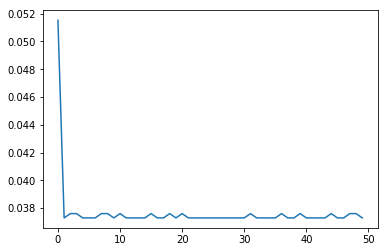

In [287]:
plt.plot(function_fitness_std(pop))

In [147]:
from deap import base, creator

In [135]:
import random
from deap import tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


IND_SIZE = 1

def my_dir():
    return(np.random.dirichlet(np.ones(12), size = 1)[0])

toolbox = base.Toolbox()
toolbox.register("attr_float",  my_dir)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



In [136]:
pop = toolbox.population(5)

In [148]:
foo = pop[0]

In [153]:
type(foo)

deap.creator.Individual

In [152]:
dir(foo)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'fitness',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [311]:
creator.create("Fitness", base.Fitness, weights=(-1.0, 1.0))
creator.create("Individual", set, fitness=creator.Fitness)

/home/marcelovmaciel/miniconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [313]:
# Create the item dictionary: item name is an integer, and value is 
# a (weight, value) 2-uple.
items = {}
# Create random items and store them in the items' dictionary.
for i in range(3):
    items[i] = (random.randint(1, 10), random.uniform(0, 100))

In [314]:
toolbox = base.Toolbox()
toolbox.register("attr_item", random.randrange, 3)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_item, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
def evaluate(individual):
    return sum(individual),

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [8]:
from tqdm import tqdm
    
def main():
    pop = toolbox.population(n=50)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 200

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in tqdm(range(NGEN)):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

    return pop

In [9]:
main()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 715.29it/s]


[[-14.769356900626843,
  -22.42133995343212,
  -14.348365063303605,
  -17.969991578358957,
  -14.292749073391796,
  -18.459667845059617,
  -25.054935607636132,
  -16.85185114098054,
  -17.712898727535006,
  -21.635660153637154,
  -15.240201994956927,
  -15.366488039067333],
 [-14.769356900626843,
  -22.42133995343212,
  -14.348365063303605,
  -17.969991578358957,
  -14.292749073391796,
  -18.459667845059617,
  -25.054935607636132,
  -16.85185114098054,
  -17.712898727535006,
  -20.6121984590088,
  -15.240201994956927,
  -15.366488039067333],
 [-14.769356900626843,
  -24.341706995859248,
  -14.348365063303605,
  -17.428848948081445,
  -13.658240533607422,
  -19.70997141103366,
  -27.187290417695525,
  -16.85185114098054,
  -17.712898727535006,
  -21.635660153637154,
  -15.240201994956927,
  -15.366488039067333],
 [-14.720111842441852,
  -24.341706995859248,
  -14.348365063303605,
  -17.428848948081445,
  -13.462424926310517,
  -19.70997141103366,
  -25.6101504755255,
  -16.8518511409805